In [1]:
import numpy as np
import matplotlib.pyplot as plt

import requests
import re
import string

from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# GPT2's tokenizer
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/Users/raeez/.pyenv/versions/jupyter-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

Hyperparams

In [4]:
# data hyperparas
seq_len = 8 # aka context length
stride = 2

#model hyperparas
embed_dim = 128
batch_size=64


Create train and test sets

In [5]:
# dowload and tokenize text
text = requests.get('https://www.gutenberg.org/files/35/35-0.txt').text
tmTokens = torch.tensor(tokenizer.encode(text))
len(tmTokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (48533 > 1024). Running this sequence through the model will result in indexing errors


48533

In [7]:
# create class for a dataset (note: batching done by DataLoader, not here)
class TokenDataset(Dataset):
    def __init__(self, tokens, seq_length=8, stride=4):

        # init
        self.inputs = []
        self.targets = []
        

        # overlapping seq of context_length
        for i in range(0,len(tokens)-seq_length,stride):
            # get context tokens and append to lists
            self.inputs.append(tokens[i : i+seq_length])
            self.targets.append(tokens[i+1 : i+seq_length+1])

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,idx):
        return self.inputs[idx], self.targets[idx]

In [8]:
# create an instnace
token_dataset = TokenDataset(tmTokens, seq_len, stride)


# spolit into train and test
train_ratio = .9
train_size = int(train_ratio * len(token_dataset))
test_size = len(token_dataset) - train_size

# create train/test subsets
train_dataset, test_dataset = random_split(token_dataset, [train_size, test_size])

# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_dataloader =  DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

#Shuffle means everytime we call dataloader, it shuffle the seq of tokens ---> used to avoid systematic bias while training 

print(f'Train has {train_size} sequences')
print(f'Test has {test_size} sequences')
#Note: these are sequences, each seq has 8 tokens iside it

Train has 21836 sequences
Test has 2427 sequences


The model

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        #embedding matrix
        self.embedding = nn.Embedding(tokenizer.vocab_size, embed_dim)

        #unembedding(linear layer)
        self.gelu = nn.GELU() # non linearity
        self.finalLinear = nn.Linear(embed_dim, tokenizer.vocab_size) # unembed layer

    def forward(self, tokx):

        #fwd pass
        x = self.embedding(tokx) # [batch, token, embed_dim]
        x = self.gelu(x)
        x = self.finalLinear(x) # [batch, token, vocab_size]
        
        return F.log_softmax(x,dim=-1)
        #NLLLoss expects input as log softmax values

        
    def generate(self, tokx, n_new_tokens=30):
        # tokx is [batch, tokens]

        for _ in range(n_new_tokens):

            # get predictions
            x = self(tokx) # reference to the model itself (i.e feed fwd sweep for tokx

            # extract the final token to predict the next
            x = x[:,-1,:]  # [batch, vocab_size]

            #as log softmax has -ve values, it will create errors with multinomial()
            # so we undo log but keep softmax
            probs = torch.exp(x)

            #probabilistically sample from distbn
            nextToken = torch.multinomial(probs, num_samples=1) # [batch,1]
            tokx = torch.cat((tokx, nextToken),dim=1) #[batch, (tokens+1)]
        return tokx
        

In [10]:
model = Model()
X,y = token_dataset[4]
out = model(X)

print(X.shape)
print(y.shape)
print(out.shape)

torch.Size([8])
torch.Size([8])
torch.Size([8, 50257])


In [11]:
print(X)
print(y)

tensor([ 1677, 13246,    38,   412, 39453,  3439, 17202,   201])
tensor([13246,    38,   412, 39453,  3439, 17202,   201,   198])


In [12]:
# confirm prob distbn
print(torch.sum(torch.exp(out))) # sums to 0 (8 here, bcoz of 8 diff seq of sum of 1)
print(torch.min(torch.exp(out)))  #non negativity
print(torch.max(torch.exp(out)))

# So the output of model is not a prob disbn (as it is logsoftmax)
# but we can convert it to prob disbn by inverting the log (i.e taking exp(out)

tensor(8.0000, grad_fn=<SumBackward0>)
tensor(3.2844e-06, grad_fn=<MinBackward1>)
tensor(0.0001, grad_fn=<MaxBackward1>)


Training

In [14]:
model = model.to(device)

In [15]:
# create loss and omptimizer funcitons
loss_function = nn.NLLLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=.001, weight_decay=.01)  
# optmizer inherits device location (GPU) from model.parameters(), so no need to explictly move optmzr to GPU

In [17]:
num_epochs = 10

#init losses
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    # init batch losses to accumulate
    epoch_loss = 0

    # loop over batches in ddata loader
    for X,y in train_dataloader:
        #move data to GPU
        X,y = X.to(device), y.to(device)

        # clear previous grads
        model.zero_grad()

        #fwd pass
        log_probs = model(X)

        #calculate losses on reshaped final target word
        log_probs_flat = log_probs.view(-1, log_probs.shape[-1])  #tokens 0:N-1
        y_flat = y.view(-1) # tokens 1:N
        loss = loss_function(log_probs_flat,y_flat)

        #bckprop
        loss.backward()
        optimizer.step()

        # sum the batch loss
        epoch_loss+= loss.item()
        #loop over batches in epoch ends here

    #evaluate the mode with test set
    with torch.no_grad():   #IMP: this switches off all calculation related to grads in the model --> we use this while evaluation of model
        testloss = 0
        for X,y in test_dataloader:
            X,y = X.to(device), y.to(device)
            out = model(X)
            out_flat = out.reshape(-1, out.shape[-1])
            thisloss = loss_function(out_flat, y.view(-1))
            testloss += thisloss.item()
            

    #scale byno of tokens in data loader
    train_loss.append(epoch_loss/ len(train_dataloader))
    test_loss.append(testloss/ len(test_dataloader))

    if epoch%2==0:
        print(f'Finished epoch {epoch+1:2}, train loss: {epoch_loss / len(train_dataloader)}, test loss: {testloss/len(test_dataloader)}')

Finished epoch  1, train loss: 4.488759678009658, test loss: 4.355960193433259
Finished epoch  3, train loss: 3.71767638998422, test loss: 3.798414343281796
Finished epoch  5, train loss: 3.3791346417533026, test loss: 3.514875568841633
Finished epoch  7, train loss: 3.1864098038589743, test loss: 3.341912395075748
Finished epoch  9, train loss: 3.062893339765002, test loss: 3.224581480026245


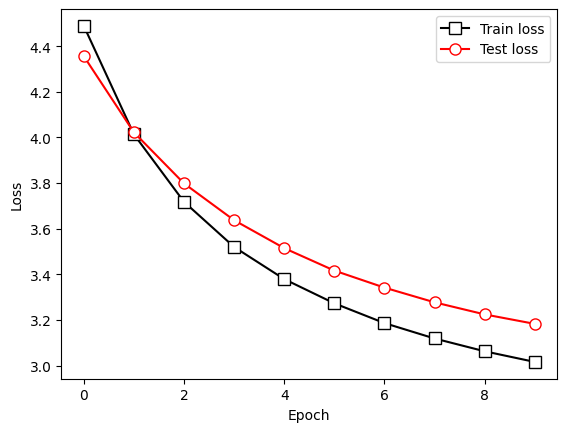

In [18]:
plt.plot(train_loss, 'ks-', markerfacecolor='w',markersize=8,label='Train loss')
plt.plot(test_loss, 'ro-', markerfacecolor='w',markersize=8,label='Test loss')

plt.legend()
plt.gca().set(xlabel='Epoch', ylabel='Loss')
plt.show()

# the training loss is lower than test loss towards the end of training
# this is bcoz of overfitting and memorization

# but in the begining its the opposite...WHY?
    # bcoz in the inital epoch, model had some learning and only then got into test set
     # so at that time when test set was evaluated, model has some knowledge already